In [1]:
import shapely
import shapely.vectorized
import re
from itertools import product, combinations

from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import geopy
import geopy.distance
import xarray as xr
import seaborn as sns
import geopandas
from scipy.spatial import distance

import cartopy.io.shapereader as shpreader

import numpy as np

import pandas as pd

In [2]:
df = pd.read_csv('../data/category_predictions.csv')
df.head()

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,6 - Water availability - k_prediction,6 - Water availability - k_prediction_binary,6 - Temperature - mean_prediction,6 - Temperature - std_prediction,6 - Temperature - lower_pred,6 - Temperature - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,Northeastern Tibetan Plateau; Tree-ring width;...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,NaN,NaN,1.000000,0.000000,1.0,1.000000,0.333333,0.471405,0.0,0.804738
2,2,1344242,This study examines the spatial and temporal p...,GIS analysis of spatial and temporal patterns ...,fire; geographic information systems; manageme...,['Forestry'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"['Engineering, Civil; Geosciences, Multidiscip...",0.0,0.0,0.0,0.0,...,NaN,NaN,0.166667,0.372678,0.0,0.539345,1.000000,0.000000,1.0,1.000000
4,4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
geos = pd.read_csv('../data/geo_df.csv')
geos = geos.drop_duplicates(["doc_id","geonameid"])
print(geos.shape)
geos.head()

(105576, 9)


,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id
0,NaN,39.76000,-98.5000,USA,6252001,United States,A,PCLI,3305893
1,NaN,22.00000,79.0000,IND,1269750,Republic of India,A,PCLI,1477550
2,NaN,60.00000,100.0000,RUS,2017370,Russian Federation,A,PCLI,1477550
3,Punjab,31.47060,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,SCHC,1477550
4,NaN,3.51342,-132.1875,NaN,2363254,Pacific Ocean,H,OCN,1477550


In [4]:
from operator import itemgetter
import ast

places = pd.read_csv('../data/place_df.csv')

places.head()

,Unnamed: 0,word,spans,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code,geonameid,place_name,feature_class
0,0,United States,"[{'start': 427, 'end': 440}]",USA,0.999811,"{'admin1': 'NA', 'lat': '39.76', 'lon': '-98.5...",3305893,39.76,-98.5,PCLI,6252001,United States,A
1,3,India,"[{'start': 140, 'end': 145}]",IND,0.999398,"{'admin1': 'NA', 'lat': '22', 'lon': '79', 'co...",1477550,22.00,79.0,PCLI,1269750,Republic of India,A
2,4,Russia,"[{'start': 697, 'end': 703}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550,60.00,100.0,PCLI,2017370,Russian Federation,A
3,5,Pakistan,"[{'start': 763, 'end': 771}]",PAK,0.989610,"{'admin1': 'Punjab', 'lat': '31.4706', 'lon': ...",1477550,30.00,70.0,PCLI,1168579,Islamic Republic of Pakistan,A
4,8,Cameroon,"[{'start': 213, 'end': 221}]",CMR,0.999931,"{'admin1': 'NA', 'lat': '6', 'lon': '12.5', 'c...",1336166,6.00,12.5,PCLI,2233387,Republic of Cameroon,A


In [5]:
df_places = pd.merge(df,places,left_on="id",right_on="doc_id")
df_places.head()

,Unnamed: 0_x,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code,geonameid,place_name,feature_class
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.999764,"{'admin1': 'NA', 'lat': '35', 'lon': '105', 'c...",136746,35.00,105.00,PCLI,1814991,People’s Republic of China,A
1,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.993103,"{'admin1': 'Qinghai', 'lat': '36', 'lon': '96'...",136746,36.00,96.00,ADM1,1280239,Qinghai Sheng,A
2,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.993103,"{'admin1': 'Inner Mongolia', 'lat': '43.5', 'l...",136746,43.50,114.75,ADM1,2035607,Inner Mongolia Autonomous Region,A
3,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.993103,{'admin1': 'Xinjiang Uyghur Autonomous Region'...,136746,41.50,85.50,ADM1,1529047,Xinjiang Uygur Zizhiqu,A
4,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.993103,"{'admin1': 'Gansu', 'lat': '37.75', 'lon': '10...",136746,37.75,102.75,ADM1,1810676,Gansu Sheng,A


## Load the D&A datasets for precip

In [62]:
df_1901_2010=xr.open_dataset('../data/d_a/9cat.190101-201012.nc').roll(LON=72, roll_coords=True)
df_1951_2010=xr.open_dataset('../data/d_a/9cat.195101-201012.nc').roll(LON=72, roll_coords=True)
df_1981_2010=xr.open_dataset('../data/d_a/9cat.198101-201012.nc').roll(LON=72, roll_coords=True)
arr_1901_2010=np.zeros([72, 144])
arr_1951_2010=np.zeros([72, 144])
arr_1981_2010=np.zeros([72, 144])

df_1951_2010.LON

<xarray.DataArray 'LON' (LON: 144)>
array([181.25, 183.75, 186.25, 188.75, 191.25, 193.75, 196.25, 198.75, 201.25,
       203.75, 206.25, 208.75, 211.25, 213.75, 216.25, 218.75, 221.25, 223.75,
       226.25, 228.75, 231.25, 233.75, 236.25, 238.75, 241.25, 243.75, 246.25,
       248.75, 251.25, 253.75, 256.25, 258.75, 261.25, 263.75, 266.25, 268.75,
       271.25, 273.75, 276.25, 278.75, 281.25, 283.75, 286.25, 288.75, 291.25,
       293.75, 296.25, 298.75, 301.25, 303.75, 306.25, 308.75, 311.25, 313.75,
       316.25, 318.75, 321.25, 323.75, 326.25, 328.75, 331.25, 333.75, 336.25,
       338.75, 341.25, 343.75, 346.25, 348.75, 351.25, 353.75, 356.25, 358.75,
         1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,  18.75,  21.25,
        23.75,  26.25,  28.75,  31.25,  33.75,  36.25,  38.75,  41.25,  43.75,
        46.25,  48.75,  51.25,  53.75,  56.25,  58.75,  61.25,  63.75,  66.25,
        68.75,  71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25,  88.75,
        91.25,  93.75,  96.25,  98.75, 101.25, 103.75, 106.25, 108.75, 111.25,
       113.75, 116.25, 118.75, 121.25, 123.75, 126.25, 128.75, 131.25, 133.75,
       136.25, 138.75, 141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25,
       158.75, 161.25, 163.75, 166.25, 168.75, 171.25, 173.75, 176.25, 178.75])
Coordinates:
  * LON      (LON) float64 181.2 183.8 186.2 188.8 ... 171.2 173.8 176.2 178.8
Attributes:
    long_name:      Longitude
    units:          degrees_east
    axis:           X
    modulo:         360.0
    point_spacing:  even
    standard_name:  longitude

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/cartopy/mpl/ticker.py:476: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: dms
  MaxNLocator.set_params(self, **kwargs)


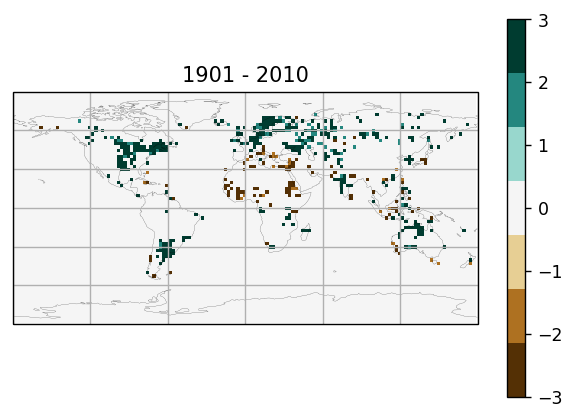

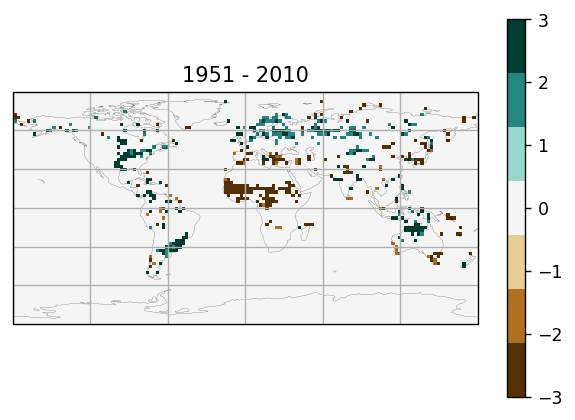

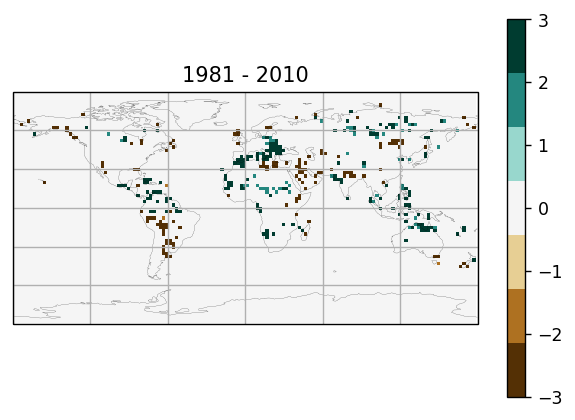

In [63]:
original_values = [4,3,2,1,0,-1,-2,-3,-4]
arr_vars = ["CP4","CP3","CP2","CP1","CP0","CM1","CM2","CM3","CM4"]
simplified_values = [3,3,2,1,0,-1,-2,-3,-3]
arrs = [arr_1901_2010, arr_1951_2010,arr_1981_2010]
dfs = [df_1901_2010, df_1951_2010, df_1981_2010]
labels = ["1901 - 2010", "1951 - 2010", "1981 - 2010"]


for arr, df_2010, label in zip(arrs, dfs, labels):
    df_2010 = df_2010.to_dataframe()
    for o_v, s_v, arr_var in zip(original_values, simplified_values, arr_vars):       
        arr[(df_2010[arr_var].values==o_v).reshape(72, 144)]=s_v
        df_2010.loc[df_2010[arr_var].values==o_v, "da_cat"] = s_v
        
    fig, ax = plt.subplots(dpi=125)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(lw=0.1)
    ax.gridlines(lw=0.1)

    mesh=ax.pcolormesh(df_1901_2010.LON.values,df_1901_2010.LAT.values,arr,cmap=plt.cm.get_cmap('BrBG',7), vmin=-3, vmax=3)
    ax.set_title(label)
    plt.colorbar(mesh)
    plt.show()
        
        

In [64]:
df_1951_2010 = df_1951_2010.to_dataframe()
for o_v, s_v, arr_var in zip(original_values, simplified_values, arr_vars):       
    arr[(df_1951_2010[arr_var].values==o_v).reshape(72, 144)]=s_v
    df_1951_2010.loc[df_1951_2010[arr_var].values==o_v, "da_cat"] = s_v
df_1951_2010 = df_1951_2010.reset_index()

In [119]:
degrees = 1
LON = np.linspace(-180+degrees*0.5,180-degrees*0.5,int(360/degrees))
LON[LON<0] += 360
LAT = np.linspace(-90+degrees*0.5,90-degrees*0.5,int(180/degrees))

lon_df, lat_df = np.meshgrid(LON,LAT)

df_places['LAT'] = df_places['lat']//degrees*degrees+degrees*0.5
df_places['LON'] = df_places['lon']//degrees*degrees+degrees*0.5
precip = df_places[
    (df_places['6 - Precipitation - mean_prediction']>0.5)
]

n = precip.groupby(['LAT','LON']).size().to_frame("n_studies").reset_index()
n.loc[n['LON']<0,"LON"] = n.loc[n['LON']<0,"LON"] + 360

ndf = ndf = (
    pd.DataFrame({"LAT": lat_df.ravel(), "LON": lon_df.ravel()})
    .merge(n,how="left")
    .fillna(0)
)
ndf["LAT_25"] = ndf['LAT']//2.5*2.5+1.25
ndf["LON_25"] = ndf['LON']//2.5*2.5+1.25
ndf['order'] = list(ndf.index)

ndf = ndf.merge(
    df_1951_2010
    .reset_index()
    .rename(columns={"LAT": "LAT_25", "LON": "LON_25"})
    [["LAT_25","LON_25","da_cat"]],
    how="inner",
    sort=False
).sort_values('order').drop(columns="order")

ndf.head()




,LAT,LON,n_studies,LAT_25,LON_25,da_cat
0,-89.5,180.5,0.0,-88.75,181.25,NaN
1,-89.5,181.5,0.0,-88.75,181.25,NaN
4,-89.5,182.5,0.0,-88.75,183.75,NaN
5,-89.5,183.5,0.0,-88.75,183.75,NaN
6,-89.5,184.5,0.0,-88.75,183.75,NaN


In [120]:
ndf.loc[(ndf['n_studies']==0),"n_study_group"] = 0
ndf.loc[(ndf['n_studies']>0) & (ndf['n_studies']<11),"n_study_group"] = 1
ndf.loc[(ndf['n_studies']>10) & (ndf['n_studies']<101),"n_study_group"] = 2
ndf.loc[(ndf['n_studies']>100) & (ndf['n_studies']<1001),"n_study_group"] = 3

In [121]:
ndf_sum = (
    ndf.groupby(['da_cat','n_study_group'])
    .size()
    .to_frame("n")
    .reset_index()
    .pivot_table(values="n",index="da_cat",columns="n_study_group")
)
ndf_sum

n_study_group,0.0,1.0,2.0,3.0
da_cat,,,,
-3.0,1143.0,70.0,2.0,NaN
-2.0,206.0,14.0,2.0,NaN
0.0,8058.0,815.0,50.0,1.0
2.0,667.0,47.0,5.0,NaN
3.0,1105.0,86.0,5.0,NaN


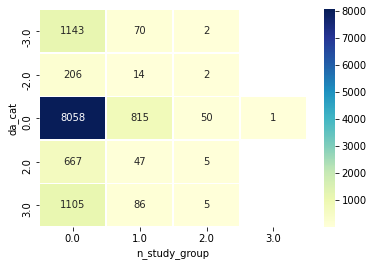

In [122]:
sns.heatmap(data=ndf_sum,cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


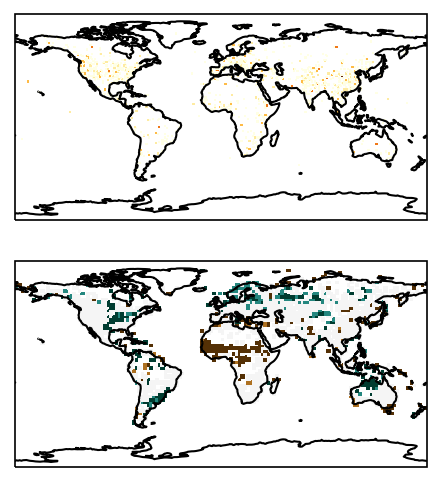

In [123]:



plt.figure(dpi=150)

ax = plt.subplot(2,1,1,projection=ccrs.PlateCarree())

n = np.array(ndf.n_studies).reshape(len(LAT),len(LON))
n[n==0] = np.nan

ax.coastlines()
mesh = ax.pcolormesh(
    ndf.LON.unique(),
    ndf.LAT.unique(),
    n,
    norm = mpl.colors.LogNorm(vmin=1, vmax=1000),
    cmap=plt.cm.get_cmap('YlOrBr',6), 
    #vmin=-4, vmax=4
)
cbar = fig.colorbar(mesh)

ax = plt.subplot(2,1,2,projection=ccrs.PlateCarree())


n = np.array(ndf.da_cat).reshape(len(LAT),len(LON))
ax.coastlines()
mesh = ax.pcolormesh(
    ndf.LON.unique(),
    ndf.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('BrBG',7), vmin=-3, vmax=3
)
cbar = fig.colorbar(mesh)


In [127]:
ndf["evidence_cat"] = np.nan

ndf.loc[
    (abs(ndf['da_cat'])>1) & (ndf['n_study_group']>0),"evidence_cat"
] = 1
ndf.loc[
    (abs(ndf['da_cat'])>1) & (ndf['n_study_group']==0),"evidence_cat"
] = 2

ndf.loc[
    (abs(ndf['da_cat'])==1) & (ndf['n_study_group']>0),"evidence_cat"
] = 5
ndf.loc[
    (abs(ndf['da_cat'])==1) & (ndf['n_study_group']==0),"evidence_cat"
] = 6

ndf.loc[
    (abs(ndf['da_cat'])==0) & (ndf['n_study_group']>0),"evidence_cat"
] = 3

ndf.loc[
    (abs(ndf['da_cat'])==0) & (ndf['n_study_group']==0),"evidence_cat"
] = 4


In [128]:
precip.groupby('feature_code').size().to_frame("n").reset_index().sort_values('n',ascending=False).head(10)

,feature_code,n
61,PCLI,1717
0,ADM1,710
68,PPL,505
2,ADM2,175
104,STM,155
55,MTS,124
50,LK,97
14,BLDG,85
69,PPLA,82
70,PPLA2,67


In [129]:
ndf.groupby("evidence_cat").size()

evidence_cat
1.0     231
2.0    3121
3.0     866
4.0    8058
dtype: int64

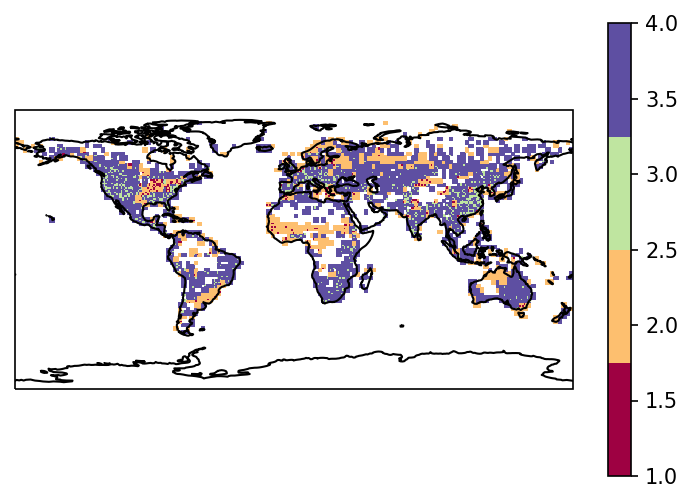

In [131]:
plt.figure(dpi=150)

ax = plt.axes(projection=ccrs.PlateCarree())

n = np.array(ndf.evidence_cat).reshape(len(LAT),len(LON))
n[n==0] = np.nan

ax.coastlines()
mesh = ax.pcolormesh(
    ndf.LON.unique(),
    ndf.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('Spectral',4), 
)
cbar = plt.colorbar(mesh)

- 4 - no d&a, no impacts
- 3 - no d&a, impacts
- 2 - d&a, no impacts
- 1 - d&a, impacts


In [133]:
nocountry_precip = precip[precip["feature_code"]!="PCLI"]
print(len(precip.doc_id.unique()))
len(nocountry_precip.doc_id.unique())

2440


1710

In [134]:
nocountry_precip.groupby('feature_code').size().sort_values(ascending=False).head(10)

feature_code
ADM1     710
PPL      505
ADM2     175
STM      155
MTS      124
LK        97
BLDG      85
PPLA      82
PPLA2     67
PLAT      65
dtype: int64

In [ ]:
#[pd.notna(ndf['da_cat'])]

def match_shp_da(shpfile, ndf):
    
    yv, xv = np.meshgrid(ndf.LAT.unique(), ndf.LON.unique())  
    gridcells = np.array(list(zip(xv.ravel(),yv.ravel())))
    xv[xv>180] -= 360

    for i, place in shpfile.iterrows():

        inplace = shapely.vectorized.contains(place.geometry,xv,yv)

        idx = np.argwhere(inplace==True)
        ndots = idx.size/2
        
        n_attributable_trend = 0
        notna_cells = 0
        
        if ndots==0:
            idx = distance.cdist([np.array(place.geometry.centroid)], gridcells).argmin()
            lon = xv.ravel()[idx]
            lat = yv.ravel()[idx]
            da_cat = attrib_df[(attrib_df['LON']==lon) & (attrib_df['LAT']==lat)]['da_cat']
            shpfile.loc[i, 'gridcells'] = 1
            if abs(da_cat.values[0]) > 1:
                n_attributable_trend +=1
            if not np.isnan(da_cat.values[0]):
                notna_cells +=1
            shpfile.loc[i, 'precip_attrib_cells'] = n_attributable_trend
            shpfile.loc[i,'precip_data_cells'] = notna_cells
            continue


        for point in idx:
            lon = ndf.LON.unique()[point[0]]
            lat = ndf.LAT.unique()[point[1]]
            da_cat = attrib_df[(attrib_df['LON']==lon) & (attrib_df['LAT']==lat)]['da_cat']

            if abs(da_cat.values[0]) > 1:
                n_attributable_trend +=1

            if not np.isnan(da_cat.values[0]):
                notna_cells +=1

        shpfile.loc[i,'gridcells'] = ndots
        shpfile.loc[i,'precip_attrib_cells'] = n_attributable_trend
        shpfile.loc[i,'precip_data_cells'] = notna_cells
        
    return shpfile

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_1_states_provinces')

adm1shps = geopandas.read_file(shpfilename)
adm1shps = match_shp_da(adm1shps, ndf)

adm1shps.head()


In [154]:
shpfilename = shpreader.natural_earth(resolution='50m',
                              category='cultural',
                              name='admin_0_countries')

adm0shps = geopandas.read_file(shpfilename)

adm0shps = match_shp_da(adm0shps, ndf)

adm0shps.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry,gridcells,precip_attrib_cells,precip_data_cells
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,Zimbabwe,ZWE,...,ZimbÃ¡bue,ÐÐ¸Ð¼Ð±Ð°Ð±Ð²Ðµ,Zimbabwe,Zimbabve,Zimbabwe,è¾å·´å¨,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344...",32.0,0.0,32.0
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,...,ZÃ¢mbia,ÐÐ°Ð¼Ð±Ð¸Ñ,Zambia,Zambiya,Zambia,èµæ¯äº,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643...",63.0,13.0,57.0
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,IÃ©men,ÐÐµÐ¼ÐµÐ½,Jemen,Yemen,Yemen,ä¹é¨,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...",39.0,0.0,9.0
3,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,Vietnam,VNM,...,Vietname,ÐÑÐµÑÐ½Ð°Ð¼,Vietnam,Vietnam,Viá»t Nam,è¶å,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...",30.0,7.0,26.0
4,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,Venezuela,VEN,...,Venezuela,ÐÐµÐ½ÐµÑÑÑÐ»Ð°,Venezuela,Venezuela,Venezuela,å§å §çæ,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...",75.0,9.0,42.0


In [155]:
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_1_states_provinces')

adm1shps = geopandas.read_file(shpfilename)
adm1shps = match_shp_da(adm1shps, ndf)

adm1shps.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry,gridcells,precip_attrib_cells,precip_data_cells
0,Admin-1 scale rank,3,ARG-1309,1309,AR-E,None,AR,1,Entre RÃ­os,Entre-Rios,...,Ð­Ð½ÑÑÐµ-Ð Ð¸Ð¾Ñ,Entre RÃ­os,Entre RÃ­os eyaleti,Entre RÃ­os,æ©ç¹é·éå¥¥æ¯ç,1159309789,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4...",8.0,8.0,8.0
1,Admin-1 scale rank,6,URY-8,8,UY-PA,None,UY,1,PaysandÃº,None,...,ÐÐ°Ð¹ÑÐ°Ð½Ð´Ñ,PaysandÃº,Paysandu DepartmanÄ±,PaysandÃº,æ´¾æ¡æç,1159307733,"POLYGON ((-58.20012 -32.44720, -58.20011 -32.4...",0.0,0.0,0.0
2,Admin-1 scale rank,3,PAK-1114,1114,PK-SD,None,PK,1,Sind,Sindh,...,Ð¡Ð¸Ð½Ð´,Sindh,Sind Eyaleti,Sindh,ä¿¡å¾·ç,1159309351,"MULTIPOLYGON (((68.18304 23.84216, 68.18301 23...",15.0,0.0,14.0
3,Admin-1 scale rank,2,IND-3264,3264,IN-GJ,None,IN,1,Gujarat,None,...,ÐÑÐ´Ð¶Ð°ÑÐ°Ñ,Gujarat,Gucerat,Gujarat,å¤åæç¹é¦,1159314179,"POLYGON ((68.18301 23.84209, 68.18304 23.84216...",14.0,3.0,9.0
4,Admin-1 scale rank,2,IDN-1185,1185,ID-KI,None,ID,5,Kalimantan Timur,Kaltim,...,ÐÐ¾ÑÑÐ¾ÑÐ½ÑÐ¹ ÐÐ°Ð»Ð¸Ð¼Ð°Ð½ÑÐ°Ð½,Kalimantan Timur,DoÄu Kalimantan,ÄÃ´ng Kalimantan,æ±å éæ¼ä¸¹ç,1159310009,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",15.0,3.0,8.0


In [139]:
shpfilename = "/home/max/Documents/resources/shpfiles/gadm36_1.shp"

adm1shps_alt = geopandas.read_file(shpfilename)

adm1shps_alt = match_shp_da(adm1shps_alt, ndf)

adm1shps_alt.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,gridcells,precip_attrib_cells
0,AFG,Afghanistan,AFG.1_1,Badakhshan,Badahšan,None,Velayat,Province,None,AF.BD,"POLYGON ((71.14804 36.00124, 71.14226 35.99334...",4.0,2.0
1,AFG,Afghanistan,AFG.2_1,Badghis,Badghes|Badghisat|Badgis,None,Velayat,Province,None,AF.BG,"POLYGON ((63.09734 34.64551, 63.08250 34.65775...",1.0,0.0
2,AFG,Afghanistan,AFG.3_1,Baghlan,Baglan|Bughlan,None,Velayat,Province,None,AF.BL,"POLYGON ((67.35538 34.88549, 67.35532 34.88847...",3.0,0.0
3,AFG,Afghanistan,AFG.4_1,Balkh,Balh|Mazar-i-Sharif|Mazar,None,Velayat,Province,None,AF.BK,"POLYGON ((66.42347 35.64057, 66.44878 35.65366...",1.0,0.0
4,AFG,Afghanistan,AFG.5_1,Bamyan,None,None,Velayat,Province,None,AF.BM,"POLYGON ((66.65279 34.00322, 66.65859 34.01669...",1.0,0.0


In [140]:
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='physical',
                                      name='geography_regions_polys')

geography = geopandas.read_file(shpfilename)

geography = match_shp_da(geography, ndf)

    

geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Altay", case=False)),"name"] = "Altay"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Appalach", case=False)),"name"] = "Appalachian Mountains"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("cant", case=False)),"name"] = "Cordillera Cantábrica"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Dabie", case=False)),"name"] = "Dabie Shan"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("EASTERN GHATS", case=False)),"name"] = "Eastern Ghāts"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("WESTERN GHATS", case=False)),"name"] = "Western Ghāts"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("kunlun", case=False)),"name"] = "Kalakunlun Shan"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("LEN MOUNTAIN", case=False)),"name"] = "Kölen"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Taihang Mts.", case=False)),"name"] = "Taihang Shan"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Tatra Mts.", case=False)),"name"] = "Tatry"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("TIAN SHAN", case=False)),"name"] = "Tien Shan"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("andes", case=False)),"name"] = "Andes Mountains"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("HINDU KUSH", case=False)),"name"] = "Hindū Kush"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Marrah Mts", case=False)),"name"] = "Jabal Marrah"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Lebanon", case=False)),"name"] = "Mount Lebanon"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("KARAKORAM RA", case=False)),"name"] = "Karakorum Shan"

geography.loc[(geography["featurecla"]=="Desert") & (geography["name"].str.contains("Negev", case=False)), "name"] = "Negev"
geography.loc[(geography["featurecla"]=="Desert") & (geography["name"].str.contains("Atacama", case=False)), "name"] = "Atacama Desert"
geography.loc[(geography["featurecla"]=="Desert") & (geography["name"].str.contains("CHIHUAHUAN DESERT", case=False)), "name"] = "Chihuahua Desert"
geography.loc[(geography["featurecla"]=="Desert") & (geography["name"].str.contains("Lut desert", case=False)), "name"] = "God-e Lut"
geography.loc[(geography["featurecla"]=="Desert") & (geography["name"].str.contains("TAKLIMAKAN DESERT", case=False)), "name"] = "Takla Makan Desert"


geography.loc[(geography["featurecla"]=="Plateau") & (geography["name"].str.contains("mongol", case=False)), "name"] = "Nei Mongol Gaoyuan"
geography.loc[(geography["featurecla"]=="Plateau") & (geography["name"].str.contains("deccan", case=False)), "name"] = "Deccan"
geography.loc[(geography["featurecla"]=="Plateau") & (geography["name"].str.contains("chota", case=False)), "name"] = "Chota Nāgpur Plateau"
geography.loc[(geography["featurecla"]=="Plateau") & (geography["name"].str.contains("loess", case=False)), "name"] = "Huangtu Gaoyuan"
geography.loc[(geography["featurecla"]=="Plateau") & (geography["name"].str.contains("khorat", case=False)), "name"] = "Khorat Plateau"
geography.loc[(geography["featurecla"]=="Plateau") & (geography["name"].str.contains("tibet", case=False)), "name"] = "Qing Zang Gaoyuan"
geography.loc[(geography["featurecla"]=="Plateau") & (geography["name"].str.contains("polar", case=False)), "name"] = "South Polar Plateau"
geography.loc[(geography["featurecla"]=="Plateau") & (geography["name"].str.contains("YUNGUI", case=False)), "name"] = "Yungui Gaoyuan"


adm0shps.loc[adm0shps.NAME.str.contains("Kosovo"),"ADM0_A3"] = "XKX"
adm0shps.loc[adm0shps.NAME.str.contains("S. Sudan"),"ADM0_A3"] = "SSD"



geography.loc[
    (geography["featurecla"]=="Plateau") & (geography["name"].str.contains("cumberland", case=False)),["name","featurecla"]
] = ["Cumberland Plateau", "Plain"]
geography.loc[
    (geography["featurecla"]=="Plateau") & (geography["name"].str.contains("colorado", case=False)),["name","featurecla"]
] = ["San Francisco Plateau", "Plain"]
geography.loc[(geography["featurecla"]=="Plain") & (geography["name"].str.contains("gange", case=False)),"name"] = "Gangetic Plain"
geography.loc[(geography["featurecla"]=="Plain") & (geography["name"].str.contains("north china", case=False)),"name"] = "Huanghuai Pingyuan"

geography.head()

,featurecla,name,namealt,region,subregion,min_label,max_label,scalerank,label,wikidataid,...,name_ru,name_sv,name_tr,name_vi,name_zh,wdid_score,ne_id,geometry,gridcells,precip_attrib_cells
0,Island,Pentecost,None,Oceania,Melanesia,6.7,12.0,7,Pentecost I.,Q960808,...,ÐÐµÐ½ÑÐµÐºÐ¾ÑÑ,Pentecost Island,None,None,å½­ç¹ç§æ¯ç¹å²,4,1159102327,"POLYGON ((168.22657 -15.98968, 168.20411 -15.9...",0.0,0.0
1,Island,Anatom,None,Oceania,Melanesia,6.7,12.0,7,Anatom,Q528884,...,ÐÐ½ÐµÐ¹ÑÑÑÐ¼,None,Anatom,None,é¿ç´æå§å³¶,4,1159102329,"POLYGON ((169.83790 -20.24737, 169.82997 -20.2...",0.0,0.0
2,Island,Gaua,None,Oceania,Melanesia,6.7,12.0,7,Gaua,Q583383,...,ÐÐ°ÑÐ°,None,None,None,å ç¦å³¶,4,1159102331,"POLYGON ((167.52491 -14.14214, 167.58619 -14.1...",0.0,0.0
3,Island,Utupua,None,Oceania,Melanesia,6.7,12.0,7,Utupua I.,Q2081472,...,Ð£ÑÑÐ¿ÑÐ°,Utupua,None,None,None,4,1159102333,"POLYGON ((166.52223 -11.27068, 166.52711 -11.2...",0.0,0.0
4,Island,Vanikolo,None,Oceania,Melanesia,6.7,12.0,7,Vanikolo,Q1536424,...,ÐÐ°Ð½Ð¸ÐºÐ¾ÑÐ¾,Vanikoro,None,None,None,4,1159102335,"POLYGON ((166.93263 -11.66021, 166.91822 -11.6...",0.0,0.0


In [141]:
geography.groupby("featurecla").size().sort_values(ascending=False)

featurecla
Island             295
Range/mtn          222
Island group       160
Plateau             70
Desert              58
Pen/cape            57
Geoarea             43
Coast               37
Plain               32
Delta               12
Peninsula           11
Basin                9
Continent            7
Valley               6
Lowland              5
Isthmus              4
Tundra               4
Gorge                3
Foothills            3
Lake                 3
Wetlands             3
Depression           2
Dragons-be-here      1
dtype: int64

In [142]:
places.groupby('feature_code')['doc_id'].count().sort_values(ascending=False).head(5)

feature_code
PCLI    31867
ADM1    15115
PPL      8883
ADM2     5265
BLDG     2406
Name: doc_id, dtype: int64

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

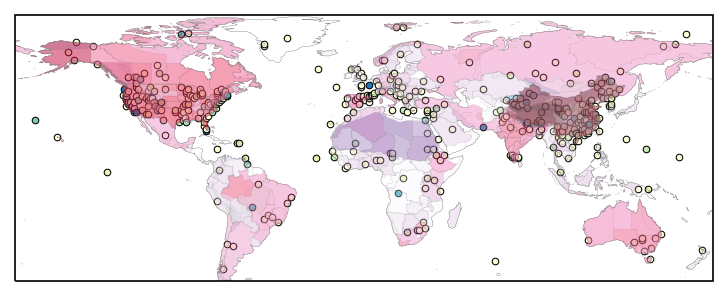

In [146]:
plt.figure(dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(lw=0.1)

precip_studies = df.loc[
    (df['6 - Precipitation - mean_prediction']>0.5)
]
precip_studies["precip_da"] = None
precip_studies["gridcells"] = None
precip_studies["attrib_cells"] = None
precip_studies["feature_type"] = None

feature_mapping = {
    "MTS": {"shpfile": geography, "featurecla_list": ["Range/mtn"]},
    "PLAT": {"shpfile": geography, "featurecla_list": ["Plateau"]},
    "PLN": {"shpfile": geography, "featurecla_list": ["Plain"]},
    "DSRT": {"shpfile": geography, "featurecla_list": ["Desert"]},
    #"BAY": {"shpfile": geography, "featurecla_list": ["Coast","Basin","Delta"]},
    "ADM1": {"shpfile": adm1shps, "featurecla_list": None},
    "PCLI": {"shpfile": adm0shps, "featurecla_list": None},
}

colors = ["Blues","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]

draw_pixellated = False
print_unfound = False

for i, (key, value) in enumerate(feature_mapping.items()):
    # Get the precip places with this type of feature
    sub_df = precip[precip["feature_code"]==key] 
    
    cm = mpl.cm.get_cmap(colors[i])
    norm = mpl.colors.LogNorm(vmin=1,vmax=sub_df.groupby('geonameid').size().max())
    
    cn = np.zeros([len(LAT), len(LON)])
    
    # Cycle through each place name
    for name, group in sub_df.groupby('place_name'):
        
        # How many studies are there with this placename
        n = len(group.doc_id.unique())
        
        # Get the matching shapefile
        shp = value["shpfile"]
        if value["featurecla_list"] is not None:
            sub_shp = shp[
                (shp["featurecla"].isin(value["featurecla_list"])) & 
                (shp["name"].str.lower().str.replace("mts.","mountains",regex=False)==name.lower().replace("mts.","mountains").strip())
            ]
        else:
            if "gn_id" in shp.columns:
                sub_shp = shp[shp["gn_id"]==group.geonameid.values[0]]
                #sub_shp = shp[shp["NAME_1"]==group.place_name.values[0]]
            else:
                sub_shp = shp[shp["ADM0_A3"]==group.country_predicted.values[0]]
                
        if sub_shp.shape[0]==0:
            if key=="ADM1":
                sub_shp = adm1shps_alt[
                    (adm1shps_alt["NAME_1"]==group.place_name.values[0]) |
                    (adm1shps_alt["VARNAME_1"].str.contains(group.place_name.values[0]))
                ]
                
        if sub_shp.shape[0]==0:
            if print_unfound:
                print(name, n, group.geonameid.values[0])
                print(name, n, group.country_predicted.values[0])   
        
        else:
            # Plot the shape coloured according to the type of feature and the number of studies in it
            ax.add_geometries(
                sub_shp.geometry,ccrs.PlateCarree(), 
                facecolor=cm(norm(n)),
                #facecolor=cm(1),
                alpha=0.3,
                zorder=1, lw=0.2, edgecolor="grey"
            )
            # As long as this is the smallest feature in the document, give it a precip_da value which
            # is the number of cells with a d&a signal divided by the total number of cells in the feature
            grid_vars = [
                sub_shp.gridcells.values[0], 
                sub_shp.precip_attrib_cells.values[0], 
                sub_shp.precip_attrib_cells.values[0] / sub_shp.gridcells.values[0],
                key
            ]
            for did in group.doc_id.unique():
                precip_studies.loc[
                    (precip_studies['id']==did) & # if the doc id matches
                    ( # and this is the smallest location object in the document
                        pd.isna(precip_studies['gridcells']) | 
                        (
                            pd.notna(precip_studies['gridcells']) &
                            precip_studies['gridcells'] > sub_shp.gridcells.values[0]
                        )                     
                    ),
                    ["gridcells", "attrib_cells", "precip_da","feature_type"]
                ] = grid_vars
            
            if draw_pixellated:
                inplace = shapely.vectorized.contains(sub_shp.geometry.values[0],xv,yv)
                idx = np.argwhere(inplace==True)

                for point in idx:
                    cn[point[1],point[0]] = 1   
            

        
    if draw_pixellated:
        cn[cn==0] = np.nan
        ax.pcolormesh(
            ndf.LON.unique()-degrees*.5,
            ndf.LAT.unique()-degrees*.5,
            cn+2,
            cmap = cm,
            norm = mpl.colors.LogNorm(vmin=1, vmax=10),
            zorder=5
        )
             
no_loc_id = precip_studies.loc[pd.isna(precip_studies['gridcells']),"id"]
sub_df = df_places[df_places["doc_id"].isin(no_loc_id)]

cm = mpl.cm.get_cmap(colors[i+1])
for name, group in sub_df.groupby(["LON","LAT"]):
    ax.scatter(
        name[0],name[1], 
        c=[len(group.doc_id.unique())], 
        norm=mpl.colors.LogNorm(vmin=1, vmax=100),
        cmap=cm, s=10, edgecolor="black",lw=0.5
    )
    

In [91]:
no_loc_id = precip_studies.loc[pd.isna(precip_studies['gridcells']),"id"]
len(no_loc_id)
#precip_studies[pd.isna(precip_studies['precip_da'])]

1439

In [89]:
df_places[df_places["doc_id"].isin(no_loc_id)].groupby("feature_code").size().sort_values(ascending=False)

feature_code
PPL      185
ADM2      55
STM       50
LK        37
BLDG      27
        ... 
HLL        1
PSH        1
HSPC       1
LIBR       1
ADM1H      1
Length: 83, dtype: int64

In [ ]:
for i, row in precip_studies.loc[pd.isna(precip_studies['gridcells']),"id"]:
    df_places[]

In [109]:
precip_da = precip[
    (precip["doc_id"].isin(no_loc_id))
][["doc_id","LAT","LON"]].merge(ndf[["LAT","LON","da_cat"]])
precip_da
precip_da["da_precip"] = np.where(abs(precip_da["da_cat"])>1,1,0)
precip_da_study = precip_da.groupby("doc_id")['da_precip'].agg(["sum","size"]).reset_index()
precip_da_study["precip_da"] =  precip_da_study["sum"] / precip_da_study["size"]
for i, row in precip_da_study.iterrows():
    precip_studies.loc[
        precip_studies["id"]==row["doc_id"],
        ["gridcells","attrib_cells","precip_da","feature_type"]
    ] = [row["size"], row["sum"], row['precip_da'], "OTHER"]
precip_da_study

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,doc_id,sum,size,precip_da
0,246,0,1,0.0
1,7051,0,2,0.0
2,9568,0,1,0.0
3,14140,0,1,0.0
4,14604,0,2,0.0
...,...,...,...,...
306,3318250,0,1,0.0
307,3319267,0,2,0.0
308,3319648,0,2,0.0
309,3322945,0,1,0.0


In [104]:
precip_studies[pd.notna(precip_studies['precip_da'])].shape

(1794, 322)

(3366, 322)
(1331, 322)
(164, 322)


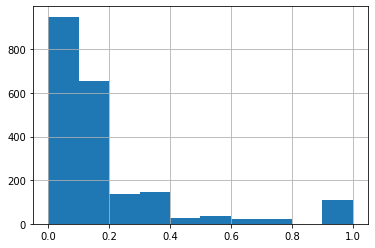

In [114]:
print(precip_studies.shape)
print(precip_studies[precip_studies["precip_da"]>0].shape)
print(precip_studies[precip_studies["precip_da"]>0.5].shape)
precip_studies.precip_da.hist()



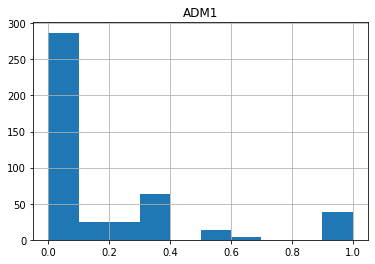

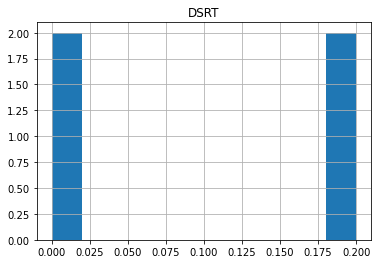

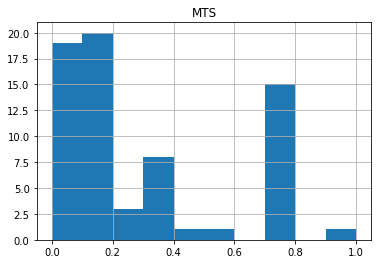

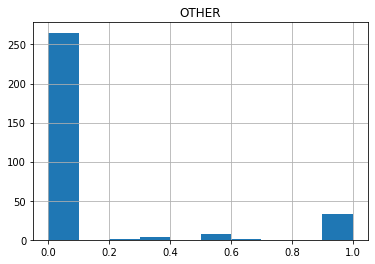

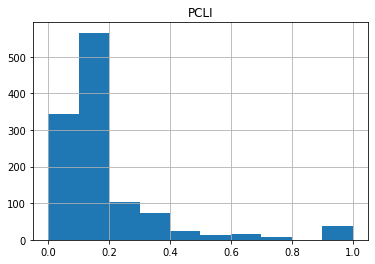

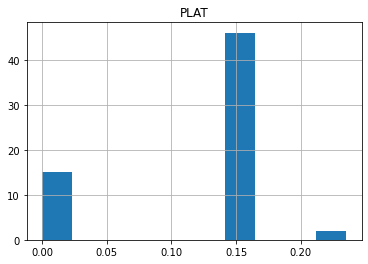

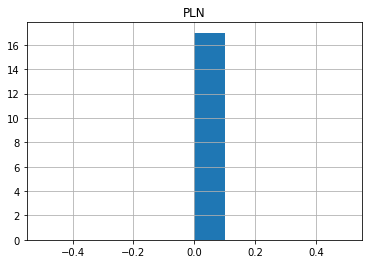

In [115]:
for name, group in precip_studies.groupby("feature_type"):
    fig, ax = plt.subplots()
    group.precip_da.hist(ax=ax)
    ax.set_title(name)